**Задание 1.**

Реализуйте нейронную сеть с двумя сверточными слоями, и одним полносвязным с нейронами с кусочно-линейной функцией активации. Какова точность построенное модели?

**Задание 2.**

Замените один из сверточных слоев на слой, реализующий операцию пулинга (Pooling) с функцией максимума или среднего. Как это повлияло на точность классификатора?

**Задание 3.**

Реализуйте классическую архитектуру сверточных сетей LeNet-5 (http://yann.lecun.com/exdb/lenet/).

**Задание 4.**

Сравните максимальные точности моделей, построенных в лабораторных работах 1-3. Как можно объяснить полученные различия?


In [103]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

In [104]:
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import random
import string

In [5]:
tf.__version__

'1.14.0'

In [6]:
large_dataset_path = '../../lab_1/src/notMNIST_large_clean.mat'
small_dataset_path = '../../lab_1/src/notMNIST_small_uniq.mat'

In [7]:
chars = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def prepare_dataset(dataset, records=None):
    data = list()
    labels = list()

    lb = preprocessing.LabelBinarizer()
    lb.fit(chars)
    
    if records:
        one = int(records / len(chars))
        #check
        for ch in chars:
            ch_len = len(dataset[ch])
            assert ch_len >= one, f'"{ch}" has {ch_len} items but required {one}'
        #print(one)
        for ch in chars:
            indexes = np.random.choice(len(dataset[ch]), one)
            picked_elements = dataset[ch][indexes] / 255
            data.extend(picked_elements)
            labels.extend(np.tile(lb.transform([ch])[0], (one, 1)))
    else:
        for ch in chars:
            data.extend(dataset[ch]/255)
            labels.extend(np.tile(lb.transform([ch])[0], (len(dataset[ch]), 1)))
    
    data = np.array(data)
    labels = np.array(labels)
    
    return resample(data, labels)

In [8]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

In [9]:
small_data = scipy.io.loadmat(small_dataset_path)
test_X, test_y = prepare_dataset(small_data, 2000)
test_X.shape

(2000, 784)

In [71]:
large_data = scipy.io.loadmat(large_dataset_path)
train_X, train_y = prepare_dataset(large_data, 10000)
train_X.shape

(10000, 784)

In [11]:
def rand_str(str_len=20):
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=str_len))

In [107]:
class BaseModel():
    def __init__(self):
        self.init_basic_params()
        
        self.compile()
        
        self.tf_writer.add_graph(self.session.graph)
    
    def init_basic_params(self):
        tf.reset_default_graph()
        self.logs_path = './tf_board/' + self.__class__.__name__
        self.var_scope = rand_str()
        self.print_separator = '-' * 65
        self.session = None
        self.dropout_rate_tf = tf.placeholder(tf.float32)
        
        self.input_size = 784
        self.output_size = 10
        
        self.dropout_rate = 0.1
        
        self.start_learning_rate = 0.01
        
        self.tf_writer = tf.summary.FileWriter(self.logs_path)
    
    def __del__(self): 
        print('object del')
        if self.session:
            tf.reset_default_graph()
            self.session.close()
    
    def reset_internal_params(self):
        self.hidden_layers = {}
        self.hidden_layers_W = {}
        self.hidden_layers_b = {}
        self.history = {
            'acc_train': [],
            'acc_valid': [],
            'loss_train': [],
            'loss_valid': []
        }
        
        self.global_step = tf.Variable(0, trainable=False)
        self.decay_steps = tf.Variable(100000, trainable=False)
    
    def get_W(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        W = tf.Variable(tf.truncated_normal(shape, stddev=0.1, mean=0), name=f'W_{layer_id}')
        self.hidden_layers_W[layer_id] = W

        return self.hidden_layers_W[layer_id]

    def get_b(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        self.hidden_layers_b[layer_id] = tf.Variable(tf.zeros(shape), name=f'b_{layer_id}')
        
        return self.hidden_layers_b[layer_id]
        
    def get_dense_layer(self, layer_id, prev_layer, units_count, activ=tf.nn.relu):
        input_size = prev_layer.get_shape().as_list()[1]
        
        W = self.get_W(layer_id, [input_size, units_count])
        b = self.get_b(layer_id, [units_count])
        
        layer = tf.matmul(prev_layer, W) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Dense_{layer_id}')
        
        return layer
    
    def get_conv2_layer(self, layer_id, prev_layer, kernel_size, output_channels, strides=1, padding='SAME', activ=tf.nn.relu):
        input_channels = prev_layer.get_shape().as_list()[3]
        
        # 5x5 conv, 1 input, 32 outputs
        # [filter_height, filter_width, in_channels, out_channels]
        filter_shape = [kernel_size[0], kernel_size[1], input_channels, output_channels]

        W = self.get_W(layer_id, filter_shape)
        b = self.get_b(layer_id, [output_channels])
        
        layer = tf.nn.conv2d(prev_layer, W, [1, strides, strides, 1], padding) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Conv2d_{layer_id}')  
        
        return layer
    
    def next_batch(self, x, y, batch_size, iteration):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        
        return x[start:end], y[start:end]
    
    def flatten(self, input):
        shape = input.get_shape().as_list()
        shape = np.array(shape)
        size = shape[shape != None].prod()
        
        return tf.reshape(input, [-1, size], name='Flatten')
    
    def get_max_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.max_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'max_pool_{layer_id}')

    def get_avg_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.avg_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'avg_pool_{layer_id}')
    
    def pre_compile():
        print('precompile')
    
    def compile(self):
        
        self.lr = tf.placeholder(tf.float32, shape=[])
        
        self.pre_compile()
        
        self.prediction = tf.nn.softmax(self.layer_output, name='Output')
        self.accuracy = tf.reduce_mean(
            tf.cast(
                tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.expected_output, 1)),
                tf.float32,
            ),
            name='Accuracy'
        )
                
        self.session = tf.Session()
        self.vars = tf.global_variables_initializer()
        self.session.run(tf.global_variables_initializer())
        
    def fit(self, x=None, y=None, batch_size=64, epochs=1):
        
        valid_size = 0.3
        
        if len(y) * valid_size > 20_000:
            valid_size = 20_000
        
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=valid_size, random_state=50)
        
        print(f'Train size: {len(y_train)},\t Valid size: {len(y_valid)}')
        
        iterations = int(len(y_train) / batch_size)
        
        display_info = int(iterations / 2)
        
        print(self.print_separator)
        print(f'Epochs: {epochs}\t| Iterations: {iterations}\t| Batch: {batch_size}')
        print(self.print_separator)
        
        self.session.run(self.decay_steps.assign(iterations))
        
        for epoch in range(epochs):
            x_train_epoch, y_train_epoch = resample(x_train, y_train)
            
            for iteration in range(iterations):
                x_batch, y_batch = self.next_batch(x_train_epoch, y_train_epoch, batch_size, iteration)

                feed_data = { 
                    self.input: x_batch, 
                    self.expected_output: y_batch,
                    self.dropout_rate_tf: self.dropout_rate
                }
                
                self.session.run(self.optimizer, feed_dict=feed_data)

            
            feed_data_train = { self.input: x_train, self.expected_output: y_train, self.dropout_rate_tf: 0}
            loss_train, acc_train = self.session.run([self.loss, self.accuracy], feed_dict=feed_data_train)
            
            # print(self.session.run([self.global_step, self.decay_steps, self.lr]))
            
            self.history['acc_train'].append(acc_train)
            self.history['loss_train'].append(loss_train)

            feed_data_valid = { self.input: x_valid, self.expected_output: y_valid, self.dropout_rate_tf: 0}
            loss_valid, acc_valid = self.session.run([self.loss, self.accuracy], feed_dict=feed_data_valid)

            self.history['acc_valid'].append(acc_valid)
            self.history['loss_valid'].append(loss_valid)

            print(f'Epoch {epoch + 1}: loss - Tr[{loss_train:.3f}] Va[{loss_valid:.3f}] \t acc - Tr[{acc_train:.01%}] Va[{acc_valid:.01%}]')
            print(self.print_separator)
            
    def evaluate(self, x=None, y=None):
        feed_data = { self.input: x, self.expected_output: y, self.dropout_rate_tf: 0}
        return self.session.run([self.loss, self.accuracy], feed_dict=feed_data)

In [108]:
class Model1CCD(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)

    def pre_compile(self):
        self.reset_internal_params()
        
        self.input = tf.placeholder(tf.float32, shape=[None, self.input_size], name="Input")
        self.expected_output = tf.placeholder(tf.float32, shape=[None, self.output_size], name="Y_actual")
        
        # [batch, in_height, in_width, in_channels]
        layer_1_pre = tf.reshape(self.input, [-1, 28, 28, 1])
        
        layer_1 = self.get_conv2_layer(1, layer_1_pre, [4, 4], 20, strides=1)
        
        layer_2 = self.get_conv2_layer(2, layer_1, [4, 4], 20, strides=1)
                    
        layer_3_pre = self.flatten(layer_2)
        
        layer_3 = self.get_dense_layer(3, layer_3_pre, 120)
        layer_3_do = tf.nn.dropout(layer_3, rate=self.dropout_rate_tf)
        
        self.layer_output = self.get_dense_layer(4, layer_3_do, 10, activ=None)
        
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.expected_output, logits=self.layer_output),
            name='Loss'
        )
        
        self.lr = tf.compat.v1.train.exponential_decay(self.start_learning_rate, self.global_step, self.decay_steps, 0.96)
        
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)


In [112]:
class Model2CPD(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)

    def pre_compile(self):
        self.reset_internal_params()
        
        self.input = tf.placeholder(tf.float32, shape=[None, self.input_size], name="Input")
        self.expected_output = tf.placeholder(tf.float32, shape=[None, self.output_size], name="Y_actual")
        
        # [batch, in_height, in_width, in_channels]
        layer_1_pre = tf.reshape(self.input, [-1, 28, 28, 1])
        
        layer_1 = self.get_conv2_layer(1, layer_1_pre, [4, 4], 20, strides=2)
        
        layer_2 = self.get_max_pooling(2, layer_1, 3)
                    
        layer_3_pre = self.flatten(layer_2)
        
        layer_3 = self.get_dense_layer(3, layer_3_pre, 120)
        layer_3_do = tf.nn.dropout(layer_3, rate=self.dropout_rate_tf)
        
        self.layer_output = self.get_dense_layer(4, layer_3_do, 10, activ=None)
        
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.expected_output, logits=self.layer_output),
            name='Loss'
        )
        
        self.lr = tf.compat.v1.train.exponential_decay(self.start_learning_rate, self.global_step, self.decay_steps, 0.96)
        
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)   

In [133]:
class LeNet5(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)
    
    def init_basic_params(self):
        super().init_basic_params()
        self.input_size = [32, 32, 1]
    
    def pad_x(self, x):
        temp = x.reshape(-1, 28, 28, 1)
        return np.pad(temp, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
    def fit(self, x=None, y=None, batch_size=64, epochs=1):
        x_pad = self.pad_x(x)
        super().fit(x=x_pad, y=y, batch_size=batch_size, epochs=epochs) 
        
    def evaluate(self, x=None, y=None):
        x_pad = self.pad_x(x)
        return super().evaluate(x=x_pad, y=y) 
        
    def pre_compile(self):
        self.reset_internal_params()

        self.input = tf.placeholder(tf.float32, shape=[None, *self.input_size], name="Input")
        self.expected_output = tf.placeholder(tf.float32, shape=[None, self.output_size], name="Y_actual")
   
        # Conv. out - 6, kernel - 5x5, stride = 1
        layer_1 = self.get_conv2_layer(1, self.input, [5, 5], 6, strides=1, padding='VALID', activ=tf.nn.tanh)
        
        # avg pool. filter = 2x2, stride = 2
        layer_2 = self.get_avg_pooling(2, layer_1, 2, stride=2, padding='VALID')
        
        # Conv. out - 16, kernel - 5x5, stride = 1
        layer_3 = self.get_conv2_layer(3, layer_2, [5, 5], 16, strides=1, padding='VALID', activ=tf.nn.tanh)
        
        # avg pool. filter = 2x2, stride = 2
        layer_4 = self.get_avg_pooling(4, layer_3, 2, stride=2, padding='VALID')
        
        # Conv. out - 120, kernel - 5x5, stride = 1
        layer_5 = self.get_conv2_layer(5, layer_4, [5, 5], 120, strides=1, padding='VALID', activ=tf.nn.tanh)
        
        # Dense - 84
        layer_6_pre = self.flatten(layer_5)
        
        layer_6 = self.get_dense_layer(6, layer_6_pre, 84, activ=tf.nn.tanh)
        
        self.layer_output = self.get_dense_layer(4, layer_6, 10, activ=None)
        
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.expected_output, logits=self.layer_output),
            name='Loss'
        )
        
        self.lr = tf.compat.v1.train.exponential_decay(self.start_learning_rate, self.global_step, self.decay_steps, 0.96)
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)

In [134]:
models = {
    'conv + conv + dense': Model1CCD(),
    'conv + max pool + dense': Model2CPD(),
    'LeNet5': LeNet5(),
}

# loss, accuracy
evaluation = {}

object del
object del
object del


In [128]:
train_epochs = 5
train_batch_size = 128

def train_and_evaluate(name):
    print('train_and_evaluate')
    print('-------------------')
    print(f'Model: {name}')
    print('-------------------')
    
    m = models[name]
    m.fit(train_X, train_y, batch_size=train_batch_size, epochs=train_epochs)
    evaluation[name] = m.evaluate(test_X, test_y)

In [137]:
train_and_evaluate('conv + conv + dense')

train_and_evaluate
-------------------
Model: conv + conv + dense
-------------------
Train size: 7000,	 Valid size: 3000
-----------------------------------------------------------------
Epochs: 5	| Iterations: 54	| Batch: 128
-----------------------------------------------------------------
Epoch 1: loss - Tr[1.622] Va[1.639] 	 acc - Tr[49.8%] Va[49.5%]
-----------------------------------------------------------------
Epoch 2: loss - Tr[1.046] Va[1.089] 	 acc - Tr[70.8%] Va[69.6%]
-----------------------------------------------------------------
Epoch 3: loss - Tr[0.905] Va[0.955] 	 acc - Tr[74.7%] Va[73.5%]
-----------------------------------------------------------------
Epoch 4: loss - Tr[0.831] Va[0.886] 	 acc - Tr[77.0%] Va[75.8%]
-----------------------------------------------------------------
Epoch 5: loss - Tr[0.788] Va[0.850] 	 acc - Tr[78.3%] Va[77.2%]
-----------------------------------------------------------------


In [138]:
train_and_evaluate('conv + max pool + dense')

train_and_evaluate
-------------------
Model: conv + max pool + dense
-------------------
Train size: 7000,	 Valid size: 3000
-----------------------------------------------------------------
Epochs: 5	| Iterations: 54	| Batch: 128
-----------------------------------------------------------------
Epoch 1: loss - Tr[1.765] Va[1.771] 	 acc - Tr[51.2%] Va[50.7%]
-----------------------------------------------------------------
Epoch 2: loss - Tr[1.287] Va[1.325] 	 acc - Tr[63.4%] Va[62.1%]
-----------------------------------------------------------------
Epoch 3: loss - Tr[1.065] Va[1.102] 	 acc - Tr[70.8%] Va[69.8%]
-----------------------------------------------------------------
Epoch 4: loss - Tr[0.971] Va[1.014] 	 acc - Tr[74.1%] Va[72.8%]
-----------------------------------------------------------------
Epoch 5: loss - Tr[0.907] Va[0.959] 	 acc - Tr[75.9%] Va[74.0%]
-----------------------------------------------------------------


In [135]:
train_and_evaluate('LeNet5')

train_and_evaluate
-------------------
Model: LeNet5
-------------------
Train size: 7000,	 Valid size: 3000
-----------------------------------------------------------------
Epochs: 5	| Iterations: 54	| Batch: 128
-----------------------------------------------------------------
Epoch 1: loss - Tr[2.154] Va[2.159] 	 acc - Tr[34.4%] Va[34.7%]
-----------------------------------------------------------------
Epoch 2: loss - Tr[1.987] Va[1.999] 	 acc - Tr[47.3%] Va[46.2%]
-----------------------------------------------------------------
Epoch 3: loss - Tr[1.778] Va[1.796] 	 acc - Tr[55.6%] Va[54.9%]
-----------------------------------------------------------------
Epoch 4: loss - Tr[1.589] Va[1.612] 	 acc - Tr[60.9%] Va[59.6%]
-----------------------------------------------------------------
Epoch 5: loss - Tr[1.439] Va[1.464] 	 acc - Tr[64.2%] Va[63.6%]
-----------------------------------------------------------------


In [139]:
evaluation

{'LeNet5': [1.2744762, 0.7405],
 'conv + conv + dense': [0.5175378, 0.8705],
 'conv + max pool + dense': [0.6660131, 0.8405]}

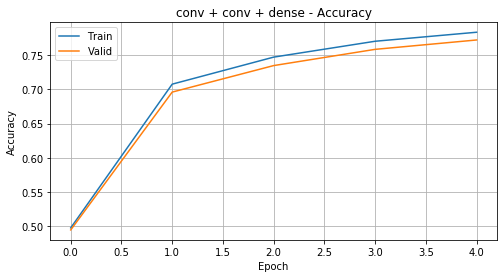

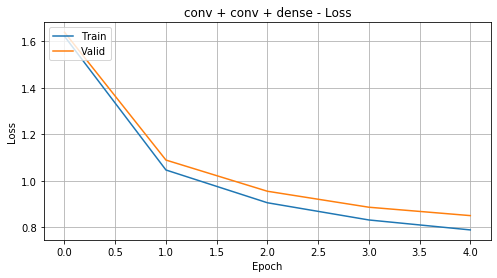

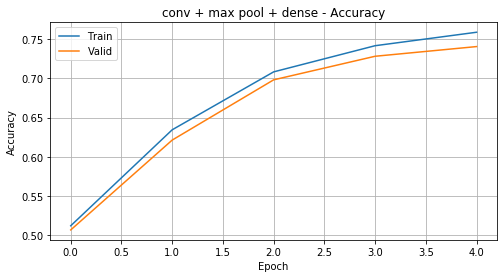

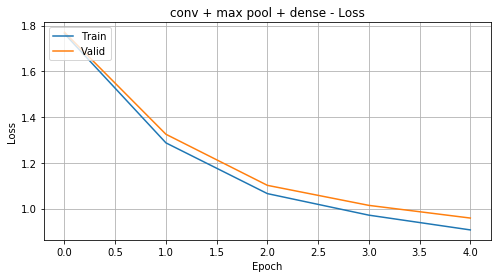

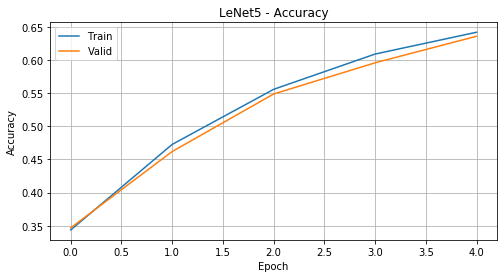

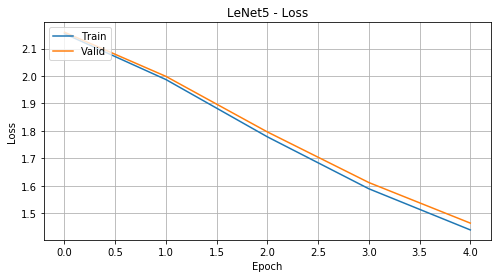

In [141]:
for name in models:
    offset = 50
    m = models[name]
    
    plot_curves(f'{name} - Accuracy', [m.history['acc_train'], m.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])
    # plot_curves(f'{name} - Accuracy', [m.history['acc_train'], m.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'], x_labels_offset=offset)
    plot_curves(f'{name} - Loss', [m.history['loss_train'], m.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])
    # plot_curves(f'{name} - Loss', [m.history['loss_train'], m.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'], x_labels_offset=offset)